<a href="https://colab.research.google.com/github/coyosi-hub/coyosi/blob/master/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.layers import Conv2D
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import random
import wandb
from wandb.keras import WandbCallback


In [ ]:

fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images.shape

train_images = train_images / 255.0
test_images = test_images / 255.0
input_shape=(28, 28, 1)


In [ ]:

config={
    "project_name" : 'coyosi',
    "learning_rate":0.001,
    "epochs": 30,
    "batch_size": 256,
    "loss_function": "sparse_categorical_crossentropy",
    "metrics" : 'accuracy',
    "architecture": "CNN",
    "dataset": "tf.keras.datasets.fashion_mnist"
    }

In [ ]:
### Setup W&B
wandb.login(key="ca9031253ddb37332ac21f4d527e9d8203bfd788")
run = wandb.init(project=config["project_name"],config=config)


wandb: Currently logged in as: coyosi (coyosi2). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


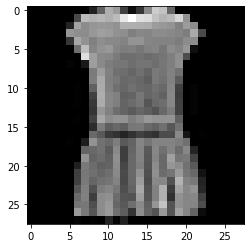

(28, 28)


In [ ]:
sample = 3
img = train_images[sample]
# plot the sample
fig = plt.figure
plt.imshow(img, cmap='gray')
plt.show()
print(img.shape)


In [ ]:
wandb.log({"img": [wandb.Image(img, caption="Dress")]})

In [ ]:
datagen = ImageDataGenerator(        
    rotation_range=90,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
for i in range (0,100):
    idx = random.randint(1,60000)
    img = train_images[idx]
    label = train_labels[idx]
    img = img.reshape ( (1,) + img.shape + (1,))
    batch_size = 1    
    for batch in datagen.flow(img, batch_size=batch_size):
        batch = batch.reshape((batch_size,28,28))
        train_images = np.concatenate((train_images, batch), axis=0)         
        break
    train_labels = np.append(train_labels,label)         
    

In [ ]:
for i in range (0,100):
    idx = random.randint(1,10000)
    img = test_images[idx]
    label = test_labels[idx]
    img = img.reshape ( (1,) + img.shape + (1,))
    batch_size = 1    
    for batch in datagen.flow(img, batch_size=batch_size):
        batch = batch.reshape((batch_size,28,28))
        test_images = np.concatenate((test_images, batch), axis=0)         
        break
    test_labels = np.append(test_labels,label)     

In [ ]:

from tensorflow.keras import regularizers

### Build a model
model = Sequential()
model.add(Dropout(rate=0.2, input_shape=input_shape))
model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=1024,activation="relu"))
model.add(Dense(units=1024,activation="relu"))
model.add(Dense(units=10, activation="softmax"))


model.summary()

optimizer = tf.keras.optimizers.Adam(config['learning_rate'])
model.compile(optimizer, loss=config['loss_function'], metrics=config['metrics'])

model.fit(train_images, train_labels, epochs=config['epochs'])

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)



print('\nTest accuracy:', test_acc)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       147584    
                                                        

In [ ]:
predictions = model.predict(x=test_images,batch_size=10,verbose=0)

In [ ]:
preds = np.argmax(predictions, axis=1)

In [ ]:
len(preds)

10100

In [ ]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_true=test_labels, y_pred=preds)
print(cm)

[[895   2  13  11   2   0  77   0   5   1]
 [  1 983   1  15   1   1   4   0   3   0]
 [ 23   2 896   8  21   0  55   0   5   1]
 [ 13   4   7 934  23   3  22   0   3   1]
 [  8   1 126  23 755   0  92   0   3   2]
 [  2   0   0   0   2 987   1  13   0  12]
 [131   0  72  26  24   1 743   0   8   0]
 [  1   1   0   4   0   3   0 980   1  21]
 [  2   0   0   6   1   5   3   1 994   0]
 [  2   0   0   0   0   5   2  29   1 970]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1006
           1       0.99      0.97      0.98      1009
           2       0.80      0.89      0.84      1011
           3       0.91      0.92      0.92      1010
           4       0.91      0.75      0.82      1010
           5       0.98      0.97      0.98      1017
           6       0.74      0.74      0.74      1005
           7       0.96      0.97      0.96      1011
           8       0.97      0.98      0.98      1012
           9       0.96      0.96      0.96      1009

    accuracy                           0.90     10100
   macro avg       0.91      0.90      0.90     10100
weighted avg       0.91      0.90      0.90     10100



In [ ]:
arr = []
dirnames = ['Top', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']
for i in range(1,6):
  sample = random.randint(10000,10099)
  img = test_images[sample]
  # plot the sample
  #fig = plt.figure
  #plt.imshow(img, cmap='gray')
  #plt.show()
  img = np.expand_dims(img, axis=0)
  preds = model.predict(img)
  top_pred_idx = np.argmax(np.array(preds[0]))
  pred_class = dirnames[top_pred_idx]
  arr = arr + [wandb.Image(img, caption=pred_class)] 
  
  #arr = arr + [wandb.Image(img, caption=pred_class)]

wandb.log({"aug images": arr})
#wandb.log({"aug images": arr})
#wandb.finish()
